<a href="https://colab.research.google.com/github/csabot3/liverAItutorial/blob/main/Lesson4_Part2_Neural_Networks_Revisited_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 4, Part 2: Neural Networks Revisited

In lesson 2, we emphasized practical implementation of U-nets for segmentation of liver CT and MRI data but we did not deeply explore some of the fundamental aspects involved with training and understanding neural network models. 

This lessons re-examines some of the fundamental neural network training concepts that were glossed over in lesson 2.

The first part of this lesson used CT data from the CHAOS dataset to look at how learning rate, the optimizer, the loss function, and the neural network architecture can have varying impacts on neural network training.

This part of lesson 4 will use MRI data to demonstrate an approach to modeling hepatic steatosis with CNN classification and regression models. However, since this is not the task which the CHAOS dataset was designed for, this lesson will in the process highlight some potential pitfalls and issues where neural network modeling can go wrong. Namely, we will show how models can have severe issues with overfitting to specific patient data rather than pathology if the training and validation datasets are inappropriately designed. 

We will also focus in this lesson on some alternative methods for setting up models using FastAI and then revisit segmentation models with model setup driven by Pandas dataframes.


In [1]:
#Import libraries/packages

!pip install pydicom #Not in Colab by default
!apt-get -qq install pv #Progress bar, also not in Colab

#Now we will import several parts of the FastAI library

!pip install fastai --upgrade -q

from IPython.display import display,HTML

from fastai.vision.all import *
from fastcore.xtras import Path
from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import os
import shutil
import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import numpy as np
from pathlib import Path
import pandas as pd
import glob
import sys

     |████████████████████████████████| 2.0 MB 7.3 MB/s 
Selecting previously unselected package pv.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../archives/pv_1.6.6-1_amd64.deb ...
Unpacking pv (1.6.6-1) ...
Setting up pv (1.6.6-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 188 kB 6.7 MB/s 
     |████████████████████████████████| 60 kB 7.5 MB/s 


In [2]:
#Check the GPU - we need a GPU runtime

!nvidia-smi

Fri Apr 15 18:56:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Get the CHAOS dataset and unzip it

!wget -q --show-progress https://zenodo.org/record/3431873/files/CHAOS_Train_Sets.zip?download=1

!unzip -q  CHAOS_Train_Sets.zip\?download\=1

CHAOS_Train_Sets.zi 100%[===================>] 849.51M  19.7MB/s    in 47s     


In [4]:
#Also get the CSV created earlier which has the fat fraction estimates
!git clone https://github.com/csabot3/liverAItutorial


Cloning into 'liverAItutorial'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 132 (delta 57), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (132/132), 127.47 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
fatfracdf1=pd.read_csv('./liverAItutorial/data/MRfatfracs.csv')

In [6]:
fatfracdf1

,Unnamed: 0,PatientIndex,FatFraction
0,0,39,1.841322
1,1,19,6.961539
2,2,5,24.624095
3,3,38,-0.486450
4,4,2,1.508953
5,5,13,5.011798
6,6,36,4.550121
7,7,34,1.402582
8,8,32,23.455046
9,9,1,1.682873


Let's briefly look at a few ways we can manipulate dataframes

In [7]:
fatfracdf1.loc[fatfracdf1['PatientIndex']==5]

,Unnamed: 0,PatientIndex,FatFraction
2,2,5,24.624095


In [8]:
rowgrabexample=fatfracdf1.loc[fatfracdf1['PatientIndex']==5]

In [9]:
fatfracdf1.loc[fatfracdf1['PatientIndex']==5]['FatFraction']

2    24.624095
Name: FatFraction, dtype: float64

In [10]:
fatfracdf1.loc[fatfracdf1['PatientIndex']==5]['FatFraction'].values

array([24.62409544])

In [11]:
fatfracdf1.loc[fatfracdf1['PatientIndex']==5]['FatFraction'].values[0]

24.62409544

In [12]:
#Set up image folders
if not os.path.exists('./images-T2'):
  os.mkdir('./images-T2')
if not os.path.exists('./images-T1'):
  os.mkdir('./images-T1')
if not os.path.exists('./images-T1-Out'):
  os.mkdir('./images-T1-Out')
if not os.path.exists('./images-T1-Diff'):
  os.mkdir('./images-T1-Diff')


#Segmentation Label Folders
#Liver only segmentation versions
if not os.path.exists('./labels-T2-Liver'):  
  os.mkdir('./labels-T2-Liver')
if not os.path.exists('./labels-T1-Liver'):  
  os.mkdir('./labels-T1-Liver')


In [13]:
#Prepare our functions for relabeling the MRI dataset, in case we want to use it later
def chaosrelabel(imx1):
  imx1[imx1<50]=0
  imx1[np.where(np.logical_and(imx1>=50,imx1<90))]=1 #Liver
  imx1[np.where(np.logical_and(imx1>=90,imx1<150))]=2 #Right kidney
  imx1[np.where(np.logical_and(imx1>=150,imx1<210))]=3 #Left kidney
  imx1[imx1>=210]=4 #Spleen
  return imx1

In [14]:
def liverrelabel(imx1):
  imx1[imx1<50]=0
  imx1[np.where(np.logical_and(imx1>=50,imx1<90))]=1 #Liver
  imx1[imx1>=90]=0 #Organs not liver
  return imx1

In [15]:
#Fixed size
fixsize=320

In [16]:
#Set aside a subset of cases for the validation dataset
valcasepicks=['1','2','3','5']

In [17]:
#Segmentation label codes
codes=['Default','Liver']

In [18]:
labelpath=Path('./Train_Sets/MR')
trainls=os.listdir(labelpath)

#Create lists which will later be used to create a dataframe
t1namels=[]
t1fatls=[]
t1fatclassls=[]
t1liverls=[]
t1segnamels=[]

t2namels=[]
t2fatls=[]
t2fatclassls=[]
t2liverls=[]
t2segnamels=[]

validflaglst1=[]
validflaglst2=[]


for f1 in trainls:

  #Get the fat values for the patient pick
  fatval1=fatfracdf1.loc[fatfracdf1['PatientIndex']==int(f1)]['FatFraction'].values[0]
  if fatval1>5:
    fatclass1='Fatty'
  else:
    fatclass1='Normal'

  if f1 in valcasepicks:
    valflag=True
  else:
    valflag=False

  #Loop through the T1 images

  dcls=sorted(os.listdir(labelpath/f1/'T1DUAL/DICOM_anon/InPhase'))
  dclsO=sorted(os.listdir(labelpath/f1/'T1DUAL/DICOM_anon/OutPhase')) #These dcms are offset as -1 relative to the in phase
  labls=sorted(os.listdir(labelpath/f1/'T1DUAL/Ground'))
  for x1 in range(0,len(dcls)):
    dcpick=labelpath/f1/'T1DUAL/DICOM_anon/InPhase'/dcls[x1]
    labpick=labelpath/f1/'T1DUAL/Ground'/labls[x1]
    savestem=labls[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem+'.tif'
    mrex=pydicom.dcmread(dcpick)
    mrimg=mrex.pixel_array
    Image.fromarray(mrimg.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1/'+savenamekeep)

    #Load the out phase under its label but save it under the inphase label in a separate folder
    dcpickO=labelpath/f1/'T1DUAL/DICOM_anon/OutPhase'/dclsO[x1]
    mrexA=pydicom.dcmread(dcpickO)
    mrimgA=mrexA.pixel_array
    Image.fromarray(mrimgA.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T1-Out/'+savenamekeep)

    #Now create a difference image file of in-phase minus out-phase

    mrdiff=mrimg.astype(np.float32)-mrimgA.astype(np.float32)
    Image.fromarray(mrdiff).resize((fixsize,fixsize)).save('./images-T1-Diff/'+savenamekeep)

   

    t1namels.append(savenamekeep) #Keep the associated file name

    #Assign labels to the list
    t1fatls.append(fatval1)
    t1fatclassls.append(fatclass1) 
    validflaglst1.append(valflag)

    #Liver only version
    imarraytemp=liverrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T1-Liver/'+str(f1)+'-'+savestem+'.png')
    t1segnamels.append(str(f1)+'-'+savestem+'.png')

    #Use a bool list for to determine whether or not the slice contains liver
    if np.sum(imarraytemp>0):
      t1liverls.append(True)
    else:
      t1liverls.append(False)


  #Loop through the T2 images
  dcls2=sorted(os.listdir(labelpath/f1/'T2SPIR/DICOM_anon'))
  labls2=sorted(os.listdir(labelpath/f1/'T2SPIR/Ground'))
  for x1 in range(0,len(dcls2)):
    dcpick=labelpath/f1/'T2SPIR/DICOM_anon'/dcls2[x1]
    labpick=labelpath/f1/'T2SPIR/Ground'/labls2[x1]
    savestem=labls2[x1].split('.')[0]
    savenamekeep=str(f1)+'-'+savestem #Does not include character suffix
    mrex=pydicom.dcmread(dcpick)
    mrimgB=mrex.pixel_array
    Image.fromarray(mrimgB.astype(np.float32)).resize((fixsize,fixsize)).save('./images-T2/'+str(f1)+'-'+savestem+'.tif')

    #Assign values to label lists

    t2namels.append(savenamekeep)
    t2fatls.append(fatval1)
    t2fatclassls.append(fatclass1)
    validflaglst2.append(valflag)

    #Liver relabel
    imarraytemp=liverrelabel(np.array(Image.open(labpick).resize((fixsize,fixsize))))
    Image.fromarray(imarraytemp.astype('uint8')).convert('L').save('./labels-T2-Liver/'+str(f1)+'-'+savestem+'.png')

    t2segnamels.append(str(f1)+'-'+savestem+'.png')

    if np.sum(imarraytemp>0):
      t2liverls.append(True)
    else:
      t2liverls.append(False)

    
    


In [19]:
t1fatdf=pd.DataFrame(list(zip(t1namels,t1fatls,t1fatclassls,validflaglst1,t1liverls,t1segnamels)),
                     columns=['Filename','FatValue','FatClass','is_valid','LiverSlice','SegmentName'])

In [20]:
t1fatdf.head() #Show the first 5 classes of this dataframe

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
0,19-IMG-0022-00002.tif,6.961539,Fatty,False,False,19-IMG-0022-00002.png
1,19-IMG-0022-00004.tif,6.961539,Fatty,False,True,19-IMG-0022-00004.png
2,19-IMG-0022-00006.tif,6.961539,Fatty,False,True,19-IMG-0022-00006.png
3,19-IMG-0022-00008.tif,6.961539,Fatty,False,True,19-IMG-0022-00008.png
4,19-IMG-0022-00010.tif,6.961539,Fatty,False,True,19-IMG-0022-00010.png


In [21]:
t2fatdf=pd.DataFrame(list(zip(t2namels,t2fatls,t2fatclassls,validflaglst2,t2liverls,t2segnamels)),
                     columns=['Filename','FatValue','FatClass','is_valid','LiverSlice','SegmentName'])

In [22]:
t2fatdf.head()

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
0,19-IMG-0024-00001,6.961539,Fatty,False,False,19-IMG-0024-00001.png
1,19-IMG-0024-00002,6.961539,Fatty,False,False,19-IMG-0024-00002.png
2,19-IMG-0024-00003,6.961539,Fatty,False,False,19-IMG-0024-00003.png
3,19-IMG-0024-00004,6.961539,Fatty,False,False,19-IMG-0024-00004.png
4,19-IMG-0024-00005,6.961539,Fatty,False,False,19-IMG-0024-00005.png


Now we have the data organized into folders and Pandas dataframes so we will use a different dataloader approach this time in FastAI that makes use of these dataframes. In lesson 2, we set up a DataBlock then used that to create the dataloader. Now, we will use FastAI dataloaders classes that have methods for going directly to the dataloader. It was beneficial earlier though to emphasize creating the datablock first.

In [23]:
#Here is an example of how we can use dataframes to subselect portions of the dataset that may be of interest
#and then we would be able to target a model to that subset
t1liveronlydf=t1fatdf.loc[t1fatdf['LiverSlice']==True] #If we want a dataframe with only slices that contain liver
t1liveronlydf.head()

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
1,19-IMG-0022-00004.tif,6.961539,Fatty,False,True,19-IMG-0022-00004.png
2,19-IMG-0022-00006.tif,6.961539,Fatty,False,True,19-IMG-0022-00006.png
3,19-IMG-0022-00008.tif,6.961539,Fatty,False,True,19-IMG-0022-00008.png
4,19-IMG-0022-00010.tif,6.961539,Fatty,False,True,19-IMG-0022-00010.png
5,19-IMG-0022-00012.tif,6.961539,Fatty,False,True,19-IMG-0022-00012.png


We will set up 2 dataloaders for comparsion now which will only differe based on the way that the training and validation sets are split. The first dataset will split the training and validation datasets by patient/case.

The second dataset, dlsrandom, will split the training and datasets randomly and intermix slices from the same patient between the 2 sets even though we have patient/case level labels... this will be shown to be quite problematic in this scenario

In [24]:
dls=ImageDataLoaders.from_df(t1fatdf,path='.',folder='images-T1-Diff', valid_col='is_valid',fn_col=0,label_col=2,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

In [25]:
#Ignore the validation column and select the validation dataset randomly, mixing between patients for the validation set
#When we run this model, we are going to see that this might not be a very good idea, in fact it's a very bad idea for this scenario
dlsrandom=ImageDataLoaders.from_df(t1fatdf,path='.',folder='images-T1-Diff',valid_pct=0.25,seed=10,fn_col=0,label_col=2,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

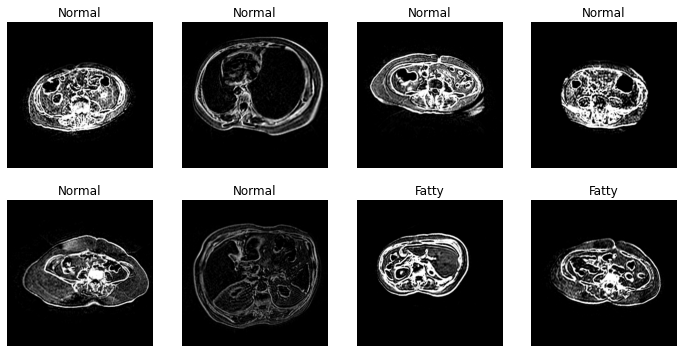

In [26]:
dls.show_batch() #Look at the inputs

In [27]:
#Let's set up our learner
learn = cnn_learner(dls, resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [28]:
learn.loss_func #Look at the default loss function (flattend cross entropy loss)

FlattenedLoss of CrossEntropyLoss()

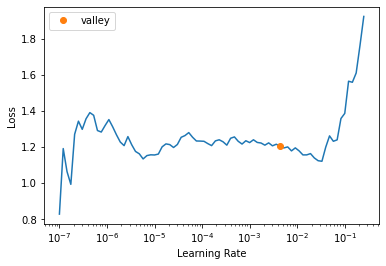

In [29]:
lrf=learn.lr_find(suggest_funcs=(valley))

In [30]:
lrf.valley

0.004365158267319202

As you can see, since these models have short training time per epoch. We are going to suppress some of the earlier output and only show what is happening for the last portion of training in our tabular form.

In [31]:
lr1 = 1e-3
with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(lr1)) #Suppress some of the output
learn.fit_one_cycle(10,slice(lr1)) #Show the last set of epochs

epoch,train_loss,valid_loss,accuracy,time
0,0.219444,0.941311,0.603306,00:06
1,0.200842,1.008558,0.652893,00:05
2,0.302557,1.023383,0.619835,00:05
3,0.222701,0.977246,0.586777,00:05
4,0.209345,0.866524,0.611570,00:05
5,0.235207,1.188923,0.561983,00:05
6,0.215975,0.922783,0.628099,00:05
7,0.252258,0.995617,0.595041,00:05
8,0.177744,1.089100,0.603306,00:05
9,0.218062,1.028766,0.595041,00:05


So...looking at performance for steatosis classification based on an appropriately split training and validation dataset...and things are not looking good. Awful really. 62% accuracy. We are going to need to think a bit more about why this is so bad (or it might seem obvious to you), but first let's train our randomly split scenario.

In [32]:
learn = cnn_learner(dlsrandom, resnet34, metrics=[accuracy])
lr1 = 1e-3
with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(lr1)) #Suppress some of the output
learn.fit_one_cycle(10,slice(lr1)) #Show the last set of epochs

epoch,train_loss,valid_loss,accuracy,time
0,0.299718,0.178316,0.931677,00:05
1,0.295586,0.200156,0.906832,00:05
2,0.302499,0.269473,0.906832,00:05
3,0.319457,0.227970,0.900621,00:05
4,0.287899,0.187590,0.931677,00:05
5,0.293012,0.171494,0.931677,00:05
6,0.247161,0.186420,0.913043,00:05
7,0.293700,0.183902,0.906832,00:05
8,0.286468,0.184551,0.900621,00:05
9,0.264248,0.164905,0.919255,00:05


Wow! Why is our model suddenly so much better when we change from the patient-based split of training and validation dataset to the random split? ... Well... it's not. These two models actually quite nicely illustrate some important considerations. In this scenario, we are treating each axial slice as a separate item. However, the labels for these slices are all identical for a given patient. So, the CNN need not learn the actual underlying pathology being targeted, but instead can readily try to memorize patients in the training dataset, since every slice for the same patient has the same label. When we split our training and validation dataset by patient case, the memorization of patients does not help performance on the validation dataset, so the bad model is indeed still shown as bad based on validation dataset accuracy.

To make matters worse, several of these slice do not even contain the liver, so trying to have a CNN learn hepatic steatosis from MRI slices not containing the liver is even more of an exercise in futility (and likely to lead to an inappropriate model which is memorizing non-liver aspects of the patient images).

Let's try again, but by selecting only slices containing the liver. We will also make sure not to perform random splits of training and validation data when we have the same label for every slice for a patient.

In [33]:
dlsliver=ImageDataLoaders.from_df(t1liveronlydf,path='.',folder='images-T1-Diff', valid_col='is_valid',fn_col=0,label_col=2,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

In [34]:
learn = cnn_learner(dlsliver, resnet34, metrics=[accuracy])
lr1 = 1e-3
with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(lr1)) #Suppress some of the output
learn.fit_one_cycle(5,slice(lr1)) #Show the last 5 epochs

epoch,train_loss,valid_loss,accuracy,time
0,0.137829,0.907223,0.703297,00:04
1,0.243691,0.913599,0.670330,00:04
2,0.273546,0.867748,0.615385,00:04
3,0.262872,0.837994,0.692308,00:04
4,0.214756,0.834587,0.670330,00:04


In [37]:
learn.unfreeze() #Unfreeze the model


In [38]:
#Now train unfrozen

with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(0.001)) #Suppress some of the output
learn.fit_one_cycle(5,slice(0.001))

epoch,train_loss,valid_loss,accuracy,time
0,0.062110,2.988850,0.461538,00:05
1,0.253135,0.978831,0.626374,00:05
2,0.191208,1.377403,0.571429,00:06
3,0.140823,1.689797,0.505495,00:05
4,0.099709,1.631940,0.472527,00:05


So...this isn't really working. It's also interesting to discuss how we have designed our model. We are doing binary classification with a 5% cut off. So a liver with 30% fat is considered the same as a liver with 6% fat in this modeling paradigm, but a liver with 5.1% fat and 4.9% fat are considered completely different. This makes sense if we are making a model to classify cats versus dogs, but it ignores that hepatic steatosis exists on a continuum.

Fortunately, we can use this same CNN architecture to model our outputs on a continuum, we will just need to switch to a regression head for the model.

In [39]:
t1liveronlydf.head()

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
1,19-IMG-0022-00004.tif,6.961539,Fatty,False,True,19-IMG-0022-00004.png
2,19-IMG-0022-00006.tif,6.961539,Fatty,False,True,19-IMG-0022-00006.png
3,19-IMG-0022-00008.tif,6.961539,Fatty,False,True,19-IMG-0022-00008.png
4,19-IMG-0022-00010.tif,6.961539,Fatty,False,True,19-IMG-0022-00010.png
5,19-IMG-0022-00012.tif,6.961539,Fatty,False,True,19-IMG-0022-00012.png


In [40]:
#Regression, change y_block to RegressionBlock
dlsliverreg=ImageDataLoaders.from_df(t1liveronlydf,path='.',folder='images-T1-Diff', y_block=RegressionBlock,
                                     valid_col='is_valid',fn_col=0,label_col=1,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

In [41]:
learn = cnn_learner(dlsliverreg, resnet34, metrics=[mse, rmse,mae])

In [42]:
learn.loss_func #We are now using mean squared error as the default loss function

FlattenedLoss of MSELoss()

In [43]:
lr1 = 1e-3
learn.fit_one_cycle(10,slice(lr1))

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,63.111992,165.831192,165.831192,12.877546,9.031515,00:04
1,48.513504,112.630013,112.630013,10.612729,7.902318,00:04
2,36.144810,84.130936,84.130936,9.172292,6.772702,00:04
3,27.880434,78.058998,78.058998,8.835100,6.549356,00:04
4,20.159376,66.321838,66.321838,8.143823,5.721720,00:05
5,17.682995,69.167526,69.167526,8.316702,5.828671,00:04
6,15.246806,64.408363,64.408363,8.025481,5.543785,00:04
7,13.752760,61.891560,61.891560,7.867118,5.376519,00:04
8,15.638416,75.876106,75.876106,8.710690,6.073614,00:04
9,15.094764,67.197601,67.197601,8.197413,5.556730,00:04


In [44]:
#Keep training
with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(lr1)) #Suppress some of the output
learn.fit_one_cycle(5,slice(lr1))

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,8.929065,54.274780,54.274780,7.367142,4.977675,00:04
1,9.931495,68.231049,68.231049,8.260209,5.416943,00:04
2,10.943479,75.233894,75.233894,8.673747,5.736249,00:04
3,11.519197,58.722012,58.722012,7.663029,5.146087,00:04
4,10.379609,49.810627,49.810627,7.057664,4.797896,00:04


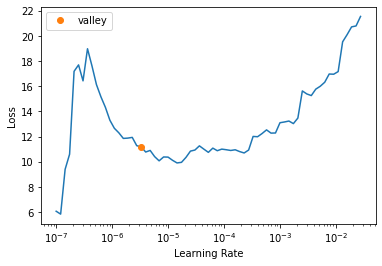

In [45]:
learn.unfreeze()
lrf=learn.lr_find(suggest_funcs=(valley))

In [46]:
lrf.valley

3.311311274956097e-06

In [47]:
#Keep training but unfrozen and with a lower learning rate

with learn.no_bar(),learn.no_logging(): learn.fit_one_cycle(20,slice(lrf.valley)) #Suppress some of the output
learn.fit_one_cycle(5,slice(lrf.valley))

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,10.464618,60.259171,60.259171,7.762678,5.248008,00:05
1,10.595071,57.882011,57.882011,7.608023,5.169988,00:05
2,9.827151,64.250954,64.250954,8.015669,5.400426,00:05
3,9.014229,55.802658,55.802658,7.470118,5.111370,00:05
4,8.773975,63.475094,63.475094,7.967126,5.382565,00:05


In [48]:
preds,targs,loss=learn.get_preds(dl=learn.dls.valid,with_loss=True,reorder=False)

Text(0.5, 1.0, 'Validation Dataset Predictions')

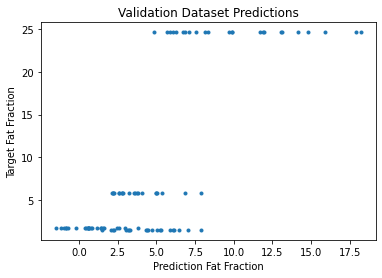

In [49]:
plt.plot(preds,targs,'.')
plt.xlabel('Prediction Fat Fraction')
plt.ylabel('Target Fat Fraction')
plt.title('Validation Dataset Predictions')

In [50]:
mae(preds,targs) #Can compute one of the metrics from the predictions and targets

TensorBase(5.3826)

So, still not great. Mean absolute error on the validation set is greater than 5 and that is more than the threshold we are using to designate steatosis. Let's see if changing the input sequence helps any, although we wouldn't necessarily expect it to.

In [51]:
dlsliverreg2=ImageDataLoaders.from_df(t1liveronlydf,path='.',folder='images-T1-Out', y_block=RegressionBlock,
                                     valid_col='is_valid',fn_col=0,label_col=1,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

In [52]:
learn = cnn_learner(dlsliverreg2, resnet34, metrics=[mse, rmse,mae])


In [53]:
learn.loss_func

FlattenedLoss of MSELoss()

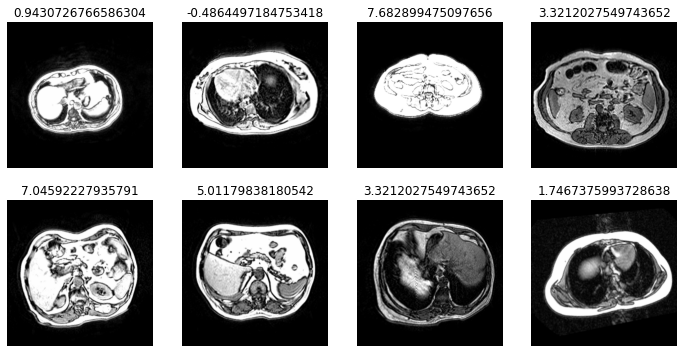

In [54]:
dlsliverreg2.show_batch() #Look at the images

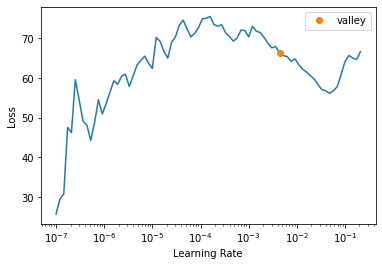

In [55]:
#Assess learning rates
lrf=learn.lr_find(suggest_funcs=(valley)) #Sometimes this will fail and can be run again in that case

In [56]:
lrf.valley

0.004365158267319202

In [57]:
learn.fit_one_cycle(10,lr1)

epoch,train_loss,valid_loss,mse,_rmse,mae,time
0,64.103294,163.822418,163.822418,12.799314,8.541870,00:04
1,46.565117,139.348297,139.348297,11.804588,8.129810,00:04
2,35.624893,132.414734,132.414734,11.507160,8.711782,00:04
3,27.273676,142.712143,142.712143,11.946219,8.689675,00:04
4,21.981234,125.428955,125.428955,11.199507,8.318438,00:04
5,17.042547,121.434753,121.434753,11.019744,8.273102,00:04
6,16.549908,133.753998,133.753998,11.565205,8.654634,00:04
7,14.046768,132.730530,132.730530,11.520874,8.688687,00:04
8,12.934607,137.570679,137.570679,11.729053,8.679757,00:04
9,12.213372,135.986420,135.986420,11.661322,8.761862,00:04


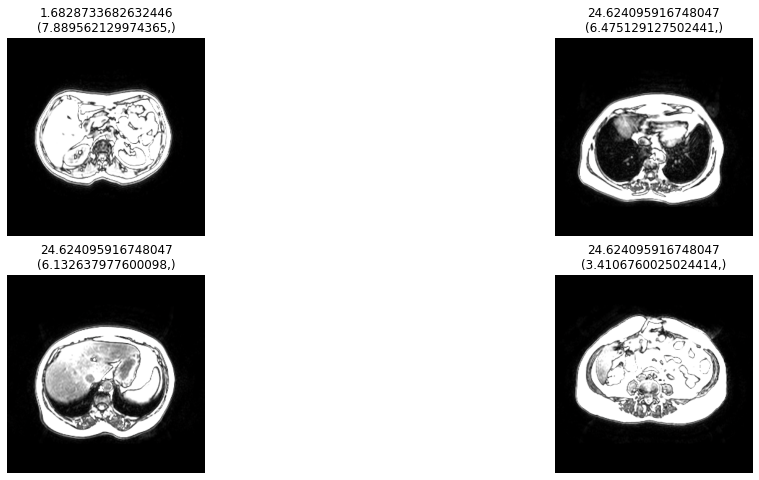

In [58]:
learn.show_results(max_n=4, figsize=(18,8))

So, given the small number of patients in our dataset, it overall is rather difficult for a model to learn weak labels if we assign a label to each exam and then train a model on individual slices. It was also not helpful to train on just, for example, the out-phase sequences compared to the difference of in-phase and out-phase sequences, as expected.

We notice the mean square error of our training data gets quite low but this performance does not carry over to the validation dataset which essentially only has 4 patients in it and as a result only 4 distinct labels for the CNN regression model validation dataset.

So, if we had a much larger dataset in terms of total number of patients, then this type of modeling paradigm of using weak labels might work better. It would also be easier to generate such a dataset with weak labels rather than detailed liver segmentations. To learn more about the concept of weak labels, consider reading this blog post from Alex Ratner and Christopher Re's group at Stanford: http://ai.stanford.edu/blog/weak-supervision/ which reviews different labeling paradigms and then discusses some of their research which relates to different strategies for dataset labeling. 

However, even though we've just explored some potential difficulties on training models where the dataset is not necessarily ideally suited for the targeted task, let's end this series of lessons on a higher note by going back to segmentation (what the CHAOS dataset was desinged for) and seeing how with dataframes we have alternative options for setting up the modeling that we did in lesson 2.


## Back to Segmentation (But now with dataframes)

In [59]:
t1fatdf.head() #Take a look at the dataframe that we want to use

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
0,19-IMG-0022-00002.tif,6.961539,Fatty,False,False,19-IMG-0022-00002.png
1,19-IMG-0022-00004.tif,6.961539,Fatty,False,True,19-IMG-0022-00004.png
2,19-IMG-0022-00006.tif,6.961539,Fatty,False,True,19-IMG-0022-00006.png
3,19-IMG-0022-00008.tif,6.961539,Fatty,False,True,19-IMG-0022-00008.png
4,19-IMG-0022-00010.tif,6.961539,Fatty,False,True,19-IMG-0022-00010.png


The FastAI documentation does not explicitly describe how to use ImageDataLoaders.from_df() for segmentation and the SegmentationDataLoaders class is not quite what we are looking for either since we want to have our valiation dataset determined from a dataframe. So, this is a case where it is important not just to look at the documentation but also the source code when available. If we look at the ImageDataLoaders source it will be quite clear how we can use from_df to set up a datablock similar to Lesson 2.

Here is a link to the source code in question for FastAIv2:
https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L136

First we can modify our dataframes file names with .apply() and lambda functions

In [60]:
t1segprep1=t1fatdf.apply(lambda xlam: './images-T1-Out/'+xlam if xlam.name == 'Filename' else xlam) 

t1segprep=t1segprep1.apply(lambda xlam: './labels-T1-Liver/'+xlam if xlam.name == 'SegmentName' else xlam) 


In [61]:
t1segprep.head() #Look at the new dataframe

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
0,./images-T1-Out/19-IMG-0022-00002.tif,6.961539,Fatty,False,False,./labels-T1-Liver/19-IMG-0022-00002.png
1,./images-T1-Out/19-IMG-0022-00004.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00004.png
2,./images-T1-Out/19-IMG-0022-00006.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00006.png
3,./images-T1-Out/19-IMG-0022-00008.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00008.png
4,./images-T1-Out/19-IMG-0022-00010.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00010.png


Now generate a dataloader for segmentation with ImageDataLoaders.from_df

In [62]:
dls_seg=ImageDataLoaders.from_df(t1segprep,path='.', y_block=MaskBlock(codes=codes),
                                     valid_col='is_valid',fn_col=0,label_col=5,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [63]:
learn = unet_learner(dls_seg, resnet34, metrics=[Dice(),JaccardCoeff()], self_attention=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


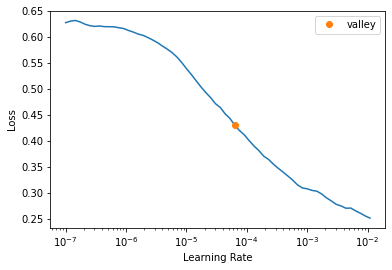

In [64]:
lrf=learn.lr_find(suggest_funcs=(valley)) 

In [65]:
lrf.valley

6.30957365501672e-05

Let's also now train in a different way. Instead of using learn.fit_one_cycle() we will use learn.fine_tune.

This is essentially a version of learn.fit_one_cycle() that handles the management of frozen and unfrozen model weights automatically in a way that is expected to work with reasonable consistency.

In lesson 2, we accepted the model before unfreezing the weights for the backbone, so the model backbone weights were not altered from pre-trained model weights which are typically trained using ImageNet: https://www.image-net.org/

Now we will have fine_tune start training for a set of epochs with frozen weights then the model will be unfrozen and the model will be trained end to end with unfrozen weights and a lower learning rate. We can see this in the docs and source code here:

https://docs.fast.ai/callback.schedule.html#Learner.fine_tune

https://github.com/fastai/fastai/blob/master/fastai/callback/schedule.py#L155

Let's try it out.

In [66]:
learn.fine_tune(20,base_lr=0.001,freeze_epochs=10)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.097858,0.065467,0.494030,0.328048,00:28
1,0.055325,0.042703,0.749216,0.598997,00:26
2,0.040079,0.044808,0.792906,0.656872,00:26
3,0.031702,0.045351,0.805774,0.674724,00:26
4,0.027652,0.052922,0.719623,0.562040,00:26
5,0.023365,0.034591,0.793312,0.657430,00:26
6,0.021867,0.031973,0.826459,0.704243,00:26
7,0.024204,0.031598,0.829117,0.708113,00:26
8,0.019559,0.027490,0.853158,0.743919,00:26
9,0.018394,0.032009,0.864218,0.760901,00:26


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.013241,0.028207,0.870863,0.771264,00:27
1,0.012539,0.034204,0.856727,0.749364,00:27
2,0.012304,0.027991,0.877147,0.781177,00:27
3,0.012284,0.029153,0.874923,0.777656,00:27
4,0.012405,0.022696,0.889478,0.800955,00:27
5,0.012958,0.028020,0.866627,0.764644,00:27
6,0.013455,0.023108,0.894823,0.809664,00:27
7,0.012744,0.024363,0.893930,0.808204,00:27
8,0.010622,0.022250,0.898180,0.815179,00:27
9,0.009803,0.019556,0.905063,0.826589,00:27


Now let's train a bit more while unfrozen (the model was unfrozen in fine_tune). But let's introduce an important concept which is a model callback. We don't necessarily just want to keep the last version of the model that we train. We might overfit and end up with lower training dataset loss but higher validation daset loss. We will do this with a callback which will save the version of our model with the lowest validation loss after every epoch. You can read more about this callback and other callback possibilities here: 

https://docs.fast.ai/callback.tracker.html#SaveModelCallback

In [67]:
#Train unfrozen with a callback to save the best model

learn.fit_one_cycle(10,slice(0.0005),
                    cbs=[SaveModelCallback(monitor='valid_loss',fname='best-T1-out-v1')]) 

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.007277,0.020650,0.911106,0.836727,00:27
1,0.007810,0.022360,0.895758,0.811198,00:27
2,0.008034,0.020581,0.909438,0.833916,00:27
3,0.008771,0.022131,0.902529,0.822372,00:27
4,0.009969,0.032289,0.834309,0.715721,00:27
5,0.008933,0.024479,0.898333,0.815430,00:27
6,0.007915,0.027029,0.898323,0.815414,00:27
7,0.007267,0.028759,0.892606,0.806041,00:27
8,0.006959,0.023655,0.906187,0.828466,00:27
9,0.006965,0.024494,0.904243,0.825222,00:27


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 0.020650489255785942.
Better model found at epoch 2 with valid_loss value: 0.020581118762493134.


In [68]:
#We can also base our callback on the Dice score rather than validation set loss
learn.fit_one_cycle(10,slice(0.0005),
                    cbs=[SaveModelCallback(monitor='dice',fname='best-T1-out-v1')]) 

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.007689,0.023102,0.906514,0.829013,00:27
1,0.007559,0.023039,0.898375,0.815500,00:27
2,0.007819,0.026884,0.896778,0.812872,00:27
3,0.008225,0.033437,0.880158,0.785966,00:27
4,0.008535,0.024728,0.893494,0.807491,00:27
5,0.008165,0.017149,0.922560,0.856252,00:27
6,0.007304,0.019613,0.919224,0.850522,00:27
7,0.007063,0.019603,0.917597,0.847740,00:27
8,0.006718,0.020796,0.913795,0.841273,00:27
9,0.006630,0.021066,0.913120,0.840130,00:27


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice value: 0.9065140437945817.
Better model found at epoch 5 with dice value: 0.922559918603257.


In [69]:
#Load the best model
learn.load('best-T1-out-v1')

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


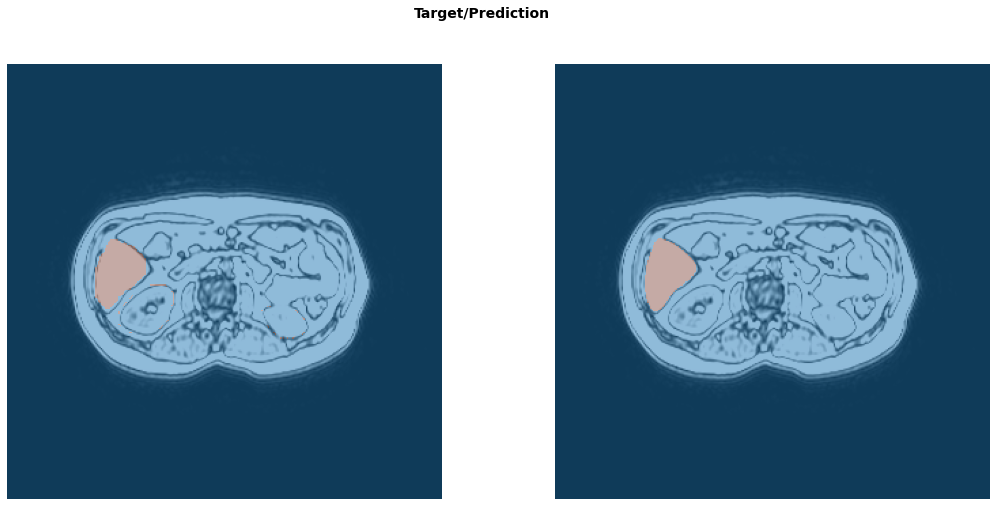

In [70]:
#Review some of the segmentations
learn.show_results(max_n=1, figsize=(18,8))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


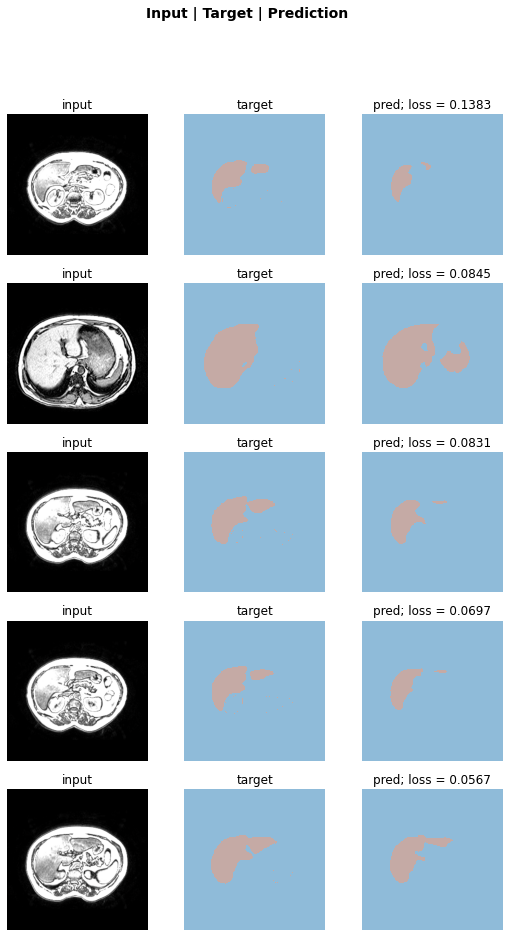

In [71]:
#Use interpretation class to review worst performing items
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(5)

We could stop here, but if we want we can make a new model where we train a model simultaneously on both the T1 in-phase and out-phase images. 

We will start by concatenating 2 dataframes and then creating a dataloader from the combined dataframe as before

In [72]:
t1segprepinA=t1fatdf.apply(lambda xlam: './images-T1/'+xlam if xlam.name == 'Filename' else xlam) 

t1segprepin=t1segprepinA.apply(lambda xlam: './labels-T1-Liver/'+xlam if xlam.name == 'SegmentName' else xlam) 

In [73]:
#Concatenate these 2 modified dataframes
t1combodf=pd.concat([t1segprep,t1segprepin],ignore_index=True)

In [74]:
t1combodf.head()

,Filename,FatValue,FatClass,is_valid,LiverSlice,SegmentName
0,./images-T1-Out/19-IMG-0022-00002.tif,6.961539,Fatty,False,False,./labels-T1-Liver/19-IMG-0022-00002.png
1,./images-T1-Out/19-IMG-0022-00004.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00004.png
2,./images-T1-Out/19-IMG-0022-00006.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00006.png
3,./images-T1-Out/19-IMG-0022-00008.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00008.png
4,./images-T1-Out/19-IMG-0022-00010.tif,6.961539,Fatty,False,True,./labels-T1-Liver/19-IMG-0022-00010.png


In [75]:
dls_segCombo=ImageDataLoaders.from_df(t1combodf,path='.', y_block=MaskBlock(codes=codes),
                                     valid_col='is_valid',fn_col=0,label_col=5,
                             batch_tfms=[*aug_transforms(size=fixsize),Normalize.from_stats(*imagenet_stats)],bs=8)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [76]:
#We have commented these lines out since the model takes about 25 minutes to train in this way
#If desired, feel free to uncomment and run or try different settings but we will skip to the next part using a model
#based on on only a single T1 sequence since the segmentation will be the same for in-phase and out-phase when
#we extract fat fraction

#learn = unet_learner(dls_segCombo, resnet34, metrics=[Dice(),JaccardCoeff()], self_attention=False)
#learn.fine_tune(15,base_lr=0.001,freeze_epochs=10)

Now we will use a segmentation model to calculate fat fraction for each study like we did in lesson 3 except by replacing the ground truth labels with U-net segmentations. We have a couple options for doing this. We can mimic the approach from lesson 3 using learn.get_preds as follows or use learn.predict on single items


In [77]:
foldertarget='./images-T1-Out/'
dlt=learn.dls.test_dl(sorted(get_image_files(foldertarget)))

In [78]:
targetnames=sorted(os.listdir(foldertarget))
len(targetnames)

647

In [79]:
preds = learn.get_preds(dl=dlt,reorder=False) 

In [80]:
len(preds[0])

647

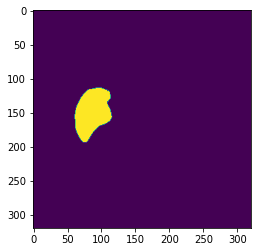

In [81]:
#Refresh on what this data looks like
examplepick=20
pred1=to_np(preds[0][examplepick])
pred1a=np.argmax(pred1,axis=0) 
plt.imshow(pred1a)

Alternatively, we could individually get predictions based on an image with learn.predict

In [82]:
predEx2=learn.predict(foldertarget+targetnames[examplepick])

In [83]:
to_np(predEx2[2]).shape #Get the probabilities

(2, 320, 320)

In [84]:
predEx2B=np.argmax(to_np(predEx2[2]),axis=0)

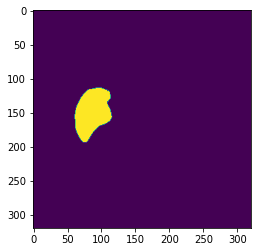

In [85]:
plt.imshow(predEx2B)

In [86]:
fixsize

320

In [87]:
foldertarget

'./images-T1-Out/'

In [88]:
#Using the first method
ptflags=np.zeros(len(targetnames))

fracmeans=np.zeros(len(targetnames))
counter=0
for (xp, xname) in zip(preds[0],targetnames):
  #Map the file name to a patient
  ptflags[counter]=int(xname.split('-')[0])
  #Get the segmentation
  segtemp=np.argmax(to_np(xp),axis=0)

  segidx=np.where(segtemp==1)

  outTemp=np.array(Image.open('./images-T1-Out/'+xname)).astype('float32')
  inTemp=np.array(Image.open('./images-T1/'+xname)).astype('float32')
  
  fracTemp=np.divide(inTemp[segidx]-outTemp[segidx],2.0*inTemp[segidx])


  fracslicemean=np.mean(fracTemp)
  fracmeans[counter]=fracslicemean*100


  counter=counter+1
  

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [89]:
#Now we will average the slice averages from the segmentations
patientls=np.unique(ptflags).astype('int')
patientls

array([ 1,  2,  3,  5,  8, 10, 13, 15, 19, 20, 21, 22, 31, 32, 33, 34, 36,
       37, 38, 39])

In [90]:
#We should also be aware that the null slices have nan as the mean
fracmeans[0:50]

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       1.16951847, 4.69110496, 1.26726618, 0.37669477, 0.54052817,
       1.26679651, 0.47797915, 0.60329922, 1.47459367, 1.32849459,
       1.64093766, 1.20971929, 0.98448852, 0.72216224, 0.59941923,
       1.47429472, 1.25966277, 1.88509692, 0.77032265, 0.86604832,
       0.21734284, 0.09839606, 0.09650672, 0.28748086, 0.09348445,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 8.69255289, 6.1758358 , 5.23432903,
       5.29850051, 6.03797957, 5.14332689, 5.22179976, 5.40222153])

In [91]:
#To calculate for a single example patient
np.nanmean(fracmeans[np.where(ptflags==3)])

6.685748586759848

In [92]:
predictfracls=[]
for ptx in patientls:
  predictfracls.append(np.nanmean(fracmeans[np.where(ptflags==ptx)]))



In [93]:
#Make a new dataframe
predictdf = pd.DataFrame(list(zip(patientls, predictfracls)),columns =['PatientIndex', 'FatFraction'])

In [94]:
predictdf

,PatientIndex,FatFraction
0,1,1.016066
1,2,2.230096
2,3,6.685749
3,5,22.590747
4,8,2.786556
5,10,6.740596
6,13,6.180703
7,15,-1.850349
8,19,7.298905
9,20,7.268914


In [95]:
#Now go back to our loaded dataframe of fat values
fatfracsorted=fatfracdf1.sort_values(by=['PatientIndex'])
fatfracsorted

,Unnamed: 0,PatientIndex,FatFraction
9,9,1,1.682873
4,4,2,1.508953
13,13,3,5.810371
2,2,5,24.624095
18,18,8,3.321203
19,19,10,7.682899
5,5,13,5.011798
14,14,15,-2.221292
1,1,19,6.961539
11,11,20,7.045923


In [96]:
gtfatvals=fatfracsorted['FatFraction'].tolist()

Text(0.5, 1.0, 'U-Net Based Fat Fraction Estimate Performance')

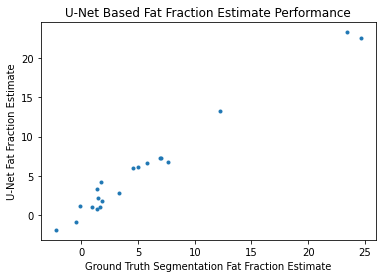

In [97]:
plt.plot(gtfatvals,predictfracls,'.')
plt.xlabel('Ground Truth Segmentation Fat Fraction Estimate')
plt.ylabel('U-Net Fat Fraction Estimate')
plt.title('U-Net Based Fat Fraction Estimate Performance')

So, this now seems like a much more reasonable way to estimate fat fraction than the weak label single slice based models we looked at earlier 

We can also quickly compute mean squared error and mean absolute error if we want to compare to the poorly performing regression models that we looked at earlier as well

In [98]:
from sklearn.metrics import mean_squared_error as skl_mse

skl_mse(gtfatvals,predictfracls)

1.2135051784967748

In [99]:
#And now MAE
np.mean(np.abs(np.array(gtfatvals)-np.array(predictfracls)))

0.8692519906083536

So, now we have approximately 1% fat fraction as the mean absolute error compared to greater than 5% when we were trying to use weak labels on single slices. By no means is this meant to imply that weak label schemes for model training do not have great potential utility. However, the purpose of looking at several ineffective and in some cases misleading models earlier in this lesson was merely to illustrate potential pratfalls and to reinforce the importance of having an AI model and dataset both make sense in the context of the problem trying to be solved.



## Conclusion

This also now brings us to the end of the final lesson in this tutorial series. However, there are still myriad AI possibilities to explore not covered in these lessons. For example, although we have explored whole organ segmentation with the CHAOS dataset, we did not look at hepatic lesion segmentation which can be done with a dataset such as LiTS: https://arxiv.org/abs/1901.04056, which would be a natural next step to pursue after these lessons. Alternatively, there are many other possibilities to explore, especially since AI research is a rapidly evolving field with a multitude of new techniques being constantly developed and refined. Learning about AI is an ongoing journey, and we wish you luck in future endeavors.

